In [ ]:
#libraries
!pip install datasets
from pandas import read_csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from datasets import ClassLabel,Sequence
import random
from IPython.display import HTML
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import gensim.downloader as api
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from gensim.models import Word2Vec
import multiprocessing
from gensim.models import FastText
import multiprocessing
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, TimeDistributed, Dense

from datasets import load_dataset

datasets_CW = load_dataset("surrey-nlp/PLOD-CW")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.2 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1072 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/126 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/153 [00:00<?, ? examples/s]

In [ ]:
# Accessing the train, test, and validation splits
train = datasets_CW['train']
test = datasets_CW['test']
validation = datasets_CW['validation']
#validation

In [ ]:
# Accessing the tokens, pos_tags, and ner_tags columns from the training data
train_tokens = train["tokens"]
train_pos_tags = train["pos_tags"]
train_ner_tags = train["ner_tags"]

from itertools import chain

# Unique values in train_ner_tags
unique_ner_tags = set(chain.from_iterable(train_ner_tags))

print("Unique values NER:", unique_ner_tags)

# Accessing the tokens, pos_tags, and ner_tags columns from the testing data
test_tokens = test["tokens"]
test_pos_tags = test["pos_tags"]
test_ner_tags = test["ner_tags"]

# Accessing the tokens, pos_tags, and ner_tags columns from the validation data
validation_tokens = validation["tokens"]
validation_pos_tags = validation["pos_tags"]
validation_ner_tags = validation["ner_tags"]
#validation_ner_tags


Unique values NER: {'B-O', 'I-LF', 'B-LF', 'B-AC'}


In [ ]:
datasets_CW

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 1072
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 126
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 153
    })
})

In [ ]:
# Observing the first 5 rows of the training data in the dataset
def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset)
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))
show_random_elements(datasets_CW["train"])

,tokens,pos_tags,ner_tags
0,"[The, three, -, parameter, model, that, did, not, incorporate, inter, -, item, homogeneity, (, as, shown, in, Figure, 8A, ), accounted, for, only, 51, %, of, the, variance, (, r, 2, ), ,, and, had, an, Akaike, information, criterion, (, AIC, ), value, (, see, Methods, ), of, 1,010, (, higher, AIC, values, indicate, worse, fit, [, 27, ], ), .]","[DET, NUM, ADJ, NOUN, NOUN, PRON, AUX, PART, VERB, ADJ, ADJ, ADJ, NOUN, PUNCT, SCONJ, VERB, ADP, NOUN, NUM, PUNCT, VERB, ADP, ADV, NUM, NOUN, ADP, DET, NOUN, PUNCT, NOUN, NUM, PUNCT, PUNCT, CCONJ, VERB, DET, PROPN, NOUN, NOUN, PUNCT, PROPN, PUNCT, NOUN, PUNCT, VERB, NOUN, PUNCT, ADP, NUM, PUNCT, ADJ, PROPN, NOUN, VERB, ADJ, NOUN, X, NUM, PUNCT, PUNCT, PUNCT]","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O]"
1,"[Abbreviations, :, CABG, ,, coronary, artery, bypass, grift, ;, PTCA, ,, percutaneous, transluminal, coronary, angioplasty, ;, ACE, :, Angiotensin, converting, enzyme, .]","[NOUN, PUNCT, PROPN, PUNCT, ADJ, NOUN, NOUN, NOUN, PUNCT, PROPN, PUNCT, ADJ, ADJ, ADJ, NOUN, PUNCT, PROPN, PUNCT, NOUN, VERB, NOUN, PUNCT]","[B-O, B-O, B-AC, B-O, B-LF, I-LF, I-LF, I-LF, B-O, B-AC, B-O, B-LF, I-LF, I-LF, I-LF, B-O, B-AC, B-O, B-LF, I-LF, I-LF, B-O]"
2,"[Photographs, showing, double, -, labeling, for, galanin, receptor, type, 2, (, GalR2, ), (, A, ,, D, ), ,, NF200, (, B, ,, E, ), ,, and, merged, images, (, C, ,, F, ), in, dorsal, root, ganglion, (, DRG, ), neurons, of, the, naïve, (, A, -, C, ), and, chronic, constriction, injury, 1, week, (, CCI1W, ), (, D, -, F, ), groups, .]","[NOUN, VERB, ADJ, PUNCT, NOUN, ADP, NOUN, NOUN, NOUN, NUM, PUNCT, PROPN, PUNCT, PUNCT, PROPN, PUNCT, PROPN, PUNCT, PUNCT, PROPN, PUNCT, NOUN, PUNCT, NOUN, PUNCT, PUNCT, CCONJ, VERB, NOUN, PUNCT, PROPN, PUNCT, PROPN, PUNCT, ADP, ADJ, NOUN, NOUN, PUNCT, PROPN, PUNCT, NOUN, ADP, DET, ADJ, PUNCT, PROPN, PUNCT, PROPN, PUNCT, CCONJ, ADJ, NOUN, NOUN, NUM, NOUN, PUNCT, PROPN, PUNCT, PUNCT, PROPN, PUNCT, PROPN, PUNCT, NOUN, PUNCT]","[B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O]"
3,"[Targeted, radionuclide, therapy, (, TRNT, ), with, alpha, particles, is, thus, complementary, to, TRNT, with, beta, particles, ,, whose, millimetric, path, is, better, suited, to, bulky, tumour, treatment, .]","[VERB, NOUN, NOUN, PUNCT, PROPN, PUNCT, ADP, NOUN, NOUN, AUX, ADV, ADJ, ADP, PROPN, ADP, NOUN, NOUN, PUNCT, DET, ADJ, NOUN, AUX, ADV, ADJ, ADP, ADJ, NOUN, NOUN, PUNCT]","[B-LF, I-LF, I-LF, B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O]"
4,"[Use, of, the, alternative, splice, site, creates, a, 5′-extended, fourth, exon, and, changes, the, reading, frame, ,, resulting, in, a, truncated, protein, ,, Loqs, protein, isoform, C, (, PC, ), ,, 383, amino, acids, long, (, Figure, 1C, ), .]","[NOUN, ADP, DET, ADJ, NOUN, NOUN, VERB, DET, ADJ, ADJ, NOUN, CCONJ, VERB, DET, NOUN, NOUN, PUNCT, VERB, ADP, DET, VERB, NOUN, PUNCT, PROPN, NOUN, NOUN, PROPN, PUNCT, PROPN, PUNCT, PUNCT, NUM, NOUN, NOUN, ADJ, PUNCT, PROPN, NUM, PUNCT, PUNCT]","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-O]"


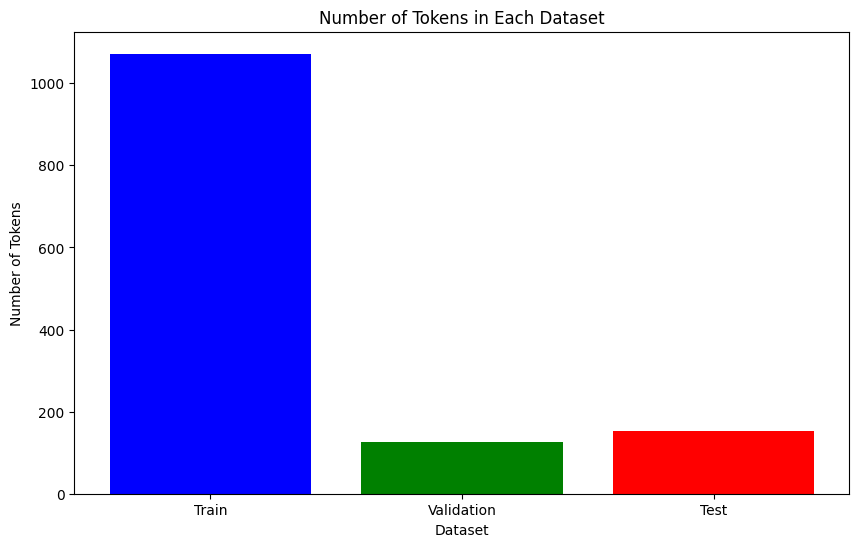

In [ ]:
import matplotlib.pyplot as plt

size_train = len(train['tokens'])
size_validation = len(validation['tokens'])
size_test = len(test['tokens'])

# Dataset names
datasets = ['Train', 'Validation', 'Test']

# Sizes of each dataset
sizes = [size_train, size_validation, size_test]

# Creating the bar graph
plt.figure(figsize=(10, 6))
plt.bar(datasets, sizes, color=['blue', 'green', 'red'])
plt.xlabel('Dataset')
plt.ylabel('Number of Tokens')
plt.title('Number of Tokens in Each Dataset')
plt.show()


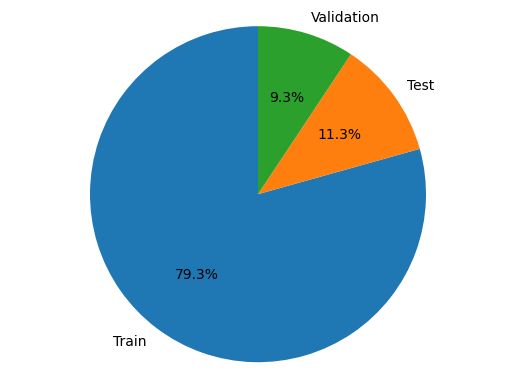

In [ ]:
import matplotlib.pyplot as plt

# Replace these with the actual lengths of your datasets
len_train = len(train["tokens"])
len_test = len(test["tokens"])
len_validation = len(validation["tokens"])
sizes = [len_train, len_test, len_validation]
labels = 'Train', 'Test', 'Validation'

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


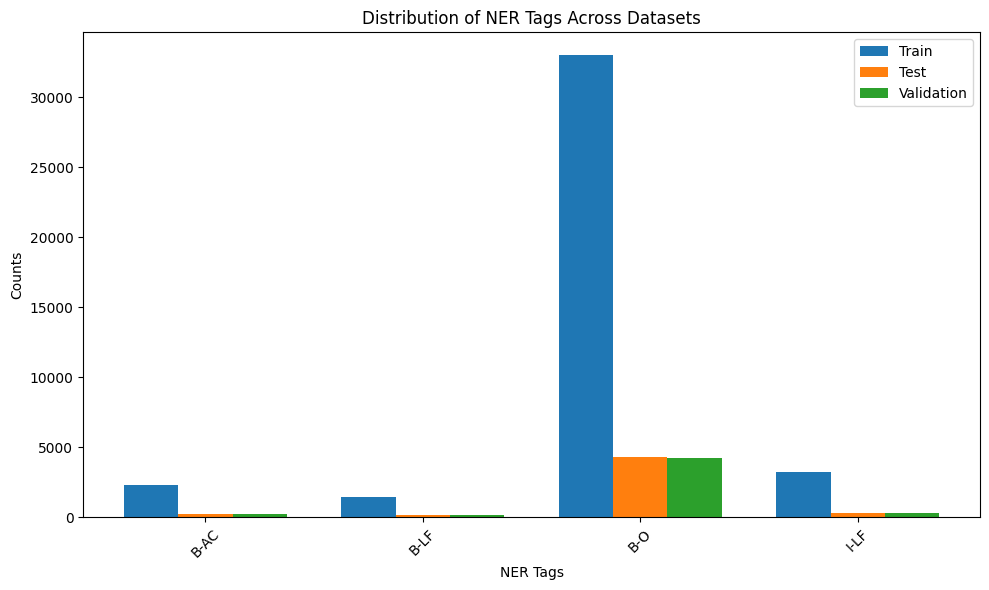

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain

# FlattenIing the list of NER tags from each dataset
flat_train_ner = list(chain.from_iterable(train['ner_tags']))
flat_test_ner = list(chain.from_iterable(test['ner_tags']))
flat_validation_ner = list(chain.from_iterable(validation['ner_tags']))

# Counting the occurrences of each NER tag in each dataset
train_ner_counts = Counter(flat_train_ner)
test_ner_counts = Counter(flat_test_ner)
validation_ner_counts = Counter(flat_validation_ner)

# Getting a sorted list of unique NER tags across all datasets
all_ner_tags = sorted(set(train_ner_counts.keys()) | set(test_ner_counts.keys()) | set(validation_ner_counts.keys()))

# Calculating the count of each NER tag for each dataset
train_tag_counts = [train_ner_counts.get(tag, 0) for tag in all_ner_tags]
test_tag_counts = [test_ner_counts.get(tag, 0) for tag in all_ner_tags]
validation_tag_counts = [validation_ner_counts.get(tag, 0) for tag in all_ner_tags]

# Setting up the bar chart
bar_width = 0.25  # Width of the bars
index = range(len(all_ner_tags))  # The x locations for the groups

# Creating the plot
plt.figure(figsize=(10, 6))
plt.bar(index, train_tag_counts, bar_width, label='Train')
plt.bar([i + bar_width for i in index], test_tag_counts, bar_width, label='Test')
plt.bar([i + bar_width * 2 for i in index], validation_tag_counts, bar_width, label='Validation')

# Adding labels and title
plt.xlabel('NER Tags')
plt.ylabel('Counts')
plt.title('Distribution of NER Tags Across Datasets')
plt.xticks([i + bar_width for i in index], all_ner_tags, rotation=45)
plt.legend()

# Displaying the plot
plt.tight_layout()  # Adjust layout to fit all labels
plt.show()


In [ ]:
# Dropping rows with missing values
train = train.filter(lambda example: example['tokens'] is not None)
validation = validation.filter(lambda example: example['tokens'] is not None)
test = test.filter(lambda example: example['tokens'] is not None)


Filter:   0%|          | 0/1072 [00:00<?, ? examples/s]

Filter:   0%|          | 0/126 [00:00<?, ? examples/s]

Filter:   0%|          | 0/153 [00:00<?, ? examples/s]

In [ ]:
# Applying fill-in-the-blanks with the most frequent value
def clean_and_transform(example):
    # We need the pos_tags and ner_tags columns
    # We will calculate the most frequent value and replace None (example)
    for column in ['pos_tags', 'ner_tags']:
        most_common = pd.Series([x for sublist in datasets_CW['train'][column] for x in sublist]).mode()[0]
        example[column] = [most_common if v is None else v for v in example[column]]
    return example

# Applying the function to all splits
datasets_CW = datasets_CW.map(clean_and_transform)

Map:   0%|          | 0/1072 [00:00<?, ? examples/s]

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Definition of preprocessing functions
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_tokens(example):
    # Tokenization
    tokens = word_tokenize(' '.join(example['tokens']))

    # Normalization
    tokens = [re.sub(r'[^A-Za-z0-9]', '', token) for token in tokens]

    # Stopwords Cleaning
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Removing empty strings
    tokens = [token for token in tokens if token.strip()]

    example['processed_tokens'] = tokens
    return example


# Application of preprocessing functions
train = train.map(preprocess_tokens)
validation = validation.map(preprocess_tokens)
test = test.map(preprocess_tokens)

# Display the first lines from each set
print("Train set processed tokens example:", train['processed_tokens'][:3])
print("Validation set processed tokens example:", validation['processed_tokens'][:3])
print("Test set processed tokens example:", test['processed_tokens'][:3])



Map:   0%|          | 0/1072 [00:00<?, ? examples/s]

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Train set processed tokens example: [['For', 'purpose', 'Gothenburg', 'Young', 'Persons', 'Empowerment', 'Scale', 'GYPES', 'developed'], ['The', 'following', 'physiological', 'trait', 'measured', 'stomatal', 'conductance', 'g', 'mol', 'H2O', 'm2', 's1', 'transpiration', 'rate', 'E', 'mmol', 'H2O', 'm2', 's1', 'net', 'photosynthetic', 'rate', 'PN', 'mol', 'm2', 's1', 'intercellular', 'CO2', 'concentration', 'CO2', 'Ci', 'mol', 'm2', 's1'], ['Minor', 'H', 'antigen', 'alloimmune', 'response', 'readily', 'occur', 'setting', 'human', 'leukocyte', 'antigen', 'HLA', 'matched', 'allogeneic', 'solid', 'organ', 'stem', 'cell', 'transplantation', 'SCT', '34']]
Validation set processed tokens example: [['Manual', 'Ability', 'Classification', 'System', 'QUEST', 'Quest', 'Quality', 'upper', 'extremity', 'skill', 'test', 'Cont', 'control', 'M', 'male', 'F', 'female', 'V', 'verbal', 'nonV', 'non', 'Verbal', 'Quad', 'quadriplegia', 'Di', 'Diplegia', 'Hemi', 'hemiplegia'], ['Electro', 'oculography', 'EO

In [ ]:
print(train)
print(validation)
print(test)

Dataset({
    features: ['tokens', 'pos_tags', 'ner_tags', 'processed_tokens'],
    num_rows: 1072
})
Dataset({
    features: ['tokens', 'pos_tags', 'ner_tags', 'processed_tokens'],
    num_rows: 126
})
Dataset({
    features: ['tokens', 'pos_tags', 'ner_tags', 'processed_tokens'],
    num_rows: 153
})


In [ ]:
# Delete original 'tokens'
train = train.remove_columns('tokens')
validation = validation.remove_columns('tokens')
test = test.remove_columns('tokens')
# Print to confirm the process
print(train)
print(validation)
print(test)

from datasets import DatasetDict

# Replace 'tokens' with 'processed tokens' and rename to 'tokens'
def replace_and_rename_tokens(example):
    example['tokens'] = example.pop('processed_tokens')
    return example

# Apply the change to each dataset
train = train.map(replace_and_rename_tokens)
validation = validation.map(replace_and_rename_tokens)
test = test.map(replace_and_rename_tokens)

# Print to confirm the process
print(train)
print(validation)
print(test)


Dataset({
    features: ['pos_tags', 'ner_tags', 'processed_tokens'],
    num_rows: 1072
})
Dataset({
    features: ['pos_tags', 'ner_tags', 'processed_tokens'],
    num_rows: 126
})
Dataset({
    features: ['pos_tags', 'ner_tags', 'processed_tokens'],
    num_rows: 153
})


Map:   0%|          | 0/1072 [00:00<?, ? examples/s]

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Dataset({
    features: ['pos_tags', 'ner_tags', 'tokens'],
    num_rows: 1072
})
Dataset({
    features: ['pos_tags', 'ner_tags', 'tokens'],
    num_rows: 126
})
Dataset({
    features: ['pos_tags', 'ner_tags', 'tokens'],
    num_rows: 153
})


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# We combine the data from all splits to create the vocabulary
all_tokens = list(chain(train['tokens'], validation['tokens'], test['tokens']))

# Creating the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_tokens)

# Convert words to numerical indices
train_seq = tokenizer.texts_to_sequences(train['tokens'])
val_seq = tokenizer.texts_to_sequences(validation['tokens'])
test_seq = tokenizer.texts_to_sequences(test['tokens'])


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# We define the maximum length
max_length = max(max(len(seq) for seq in train_seq), max(len(seq) for seq in val_seq), max(len(seq) for seq in test_seq))

# Padding
train_padded = pad_sequences(train_seq, maxlen=max_length, padding='post')
val_padded = pad_sequences(val_seq, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_seq, maxlen=max_length, padding='post')


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encoding the tags
label_encoder = LabelEncoder()
label_encoder.fit(list(chain.from_iterable(train['ner_tags'])))

# label_encoder.classes_ contains the labels in integer format
max_label = max(label_encoder.transform(label_encoder.classes_)) + 1
print(max_label)

train_labels = [label_encoder.transform(tags) for tags in train['ner_tags']]
val_labels = [label_encoder.transform(tags) for tags in validation['ner_tags']]
test_labels = [label_encoder.transform(tags) for tags in test['ner_tags']]

# Use the max_label value for padding
train_labels_padded = pad_sequences(train_labels, maxlen=max_length, padding='post', value=max_label-1)
val_labels_padded = pad_sequences(val_labels, maxlen=max_length, padding='post', value=max_label-1)
test_labels_padded = pad_sequences(test_labels, maxlen=max_length, padding='post', value=max_label-1)


4


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, TimeDistributed, Bidirectional

# Model parameters
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for zero padding
embed_dim = 128  # Dimension of  embedding
lstm_units = 64  # Number of units of LSTM
output_dim = len(label_encoder.classes_)  # Number of labels

# Model creation
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length, mask_zero=True),
    Bidirectional(LSTM(units=lstm_units, return_sequences=True)),
    TimeDistributed(Dense(output_dim, activation='softmax'))  # Using softmax for multiclass classification
])

# Set the loss function to ignore padding values
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], loss_weights=[None, 1.0])

# Show model summary
model.summary()

# Model training
history = model.fit(
    train_padded,
    np.expand_dims(train_labels_padded, -1),
    validation_data=(val_padded, val_labels_padded),
    epochs=10,
    batch_size=32)


# Evaluation of the model on the test set
test_loss, test_accuracy = model.evaluate(test_padded, test_labels_padded)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 217, 128)          1125632   
                                                                 
 bidirectional (Bidirection  (None, 217, 128)          98816     
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 217, 4)            516       
 ributed)                                                        
                                                                 
Total params: 1224964 (4.67 MB)
Trainable params: 1224964 (4.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
34/34 [==============================] - 25s 472ms/step - loss: 1.0083 - accuracy: 0.7758 - val_loss: 0.6748 - val_accuracy: 0.8399
Epoch 2

In [ ]:
from sklearn.metrics import classification_report
# Prediction on test set
test_predictions = model.predict(test_padded)
# Convert predictions from probability distributions to label index
test_predictions = np.argmax(test_predictions, axis=-1)

# We need to flatten the predictions and true values to suit the classification report
true_labels = test_labels_padded.flatten()
predicted_labels = test_predictions.flatten()

# Removing padding from the evaluation: This depends on your padding label, adjust 'max_label' accordingly
mask = true_labels < max_label - 1  # Assuming 'max_label - 1' is used for padding
true_labels = true_labels[mask]
predicted_labels = predicted_labels[mask]

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_)
print("Classification Report for full pipeline experiment:\n", report)


5/5 [==============================] - 3s 73ms/step
Classification Report for full pipeline experiment:
               precision    recall  f1-score   support

        B-AC       0.24      0.01      0.03       270
        B-LF       0.06      0.01      0.01       150
         B-O       0.91      0.98      0.95      4292
        I-LF       0.00      0.00      0.00         0

    accuracy                           0.89      4712
   macro avg       0.30      0.25      0.25      4712
weighted avg       0.85      0.89      0.86      4712



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Definition of preprocessing function just for tokenization

#Calling a new function that will only include tokenization
def preprocess_tokens(example):
    # Tokenization
    tokens = word_tokenize(' '.join(example['tokens']))

    example['processed_tokens'] = tokens
    return example


# Application of preprocessing functions
train = train.map(preprocess_tokens)
validation = validation.map(preprocess_tokens)
test = test.map(preprocess_tokens)

# Display the first lines from each set
print("Train set processed tokens example:", train['processed_tokens'][:3])
print("Validation set processed tokens example:", validation['processed_tokens'][:3])
print("Test set processed tokens example:", test['processed_tokens'][:3])


Map:   0%|          | 0/1072 [00:00<?, ? examples/s]

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Train set processed tokens example: [['For', 'purpose', 'Gothenburg', 'Young', 'Persons', 'Empowerment', 'Scale', 'GYPES', 'developed'], ['The', 'following', 'physiological', 'trait', 'measured', 'stomatal', 'conductance', 'g', 'mol', 'H2O', 'm2', 's1', 'transpiration', 'rate', 'E', 'mmol', 'H2O', 'm2', 's1', 'net', 'photosynthetic', 'rate', 'PN', 'mol', 'm2', 's1', 'intercellular', 'CO2', 'concentration', 'CO2', 'Ci', 'mol', 'm2', 's1'], ['Minor', 'H', 'antigen', 'alloimmune', 'response', 'readily', 'occur', 'setting', 'human', 'leukocyte', 'antigen', 'HLA', 'matched', 'allogeneic', 'solid', 'organ', 'stem', 'cell', 'transplantation', 'SCT', '34']]
Validation set processed tokens example: [['Manual', 'Ability', 'Classification', 'System', 'QUEST', 'Quest', 'Quality', 'upper', 'extremity', 'skill', 'test', 'Cont', 'control', 'M', 'male', 'F', 'female', 'V', 'verbal', 'nonV', 'non', 'Verbal', 'Quad', 'quadriplegia', 'Di', 'Diplegia', 'Hemi', 'hemiplegia'], ['Electro', 'oculography', 'EO

In [ ]:
print(train)
print(validation)
print(test)

Dataset({
    features: ['pos_tags', 'ner_tags', 'tokens', 'processed_tokens'],
    num_rows: 1072
})
Dataset({
    features: ['pos_tags', 'ner_tags', 'tokens', 'processed_tokens'],
    num_rows: 126
})
Dataset({
    features: ['pos_tags', 'ner_tags', 'tokens', 'processed_tokens'],
    num_rows: 153
})


In [ ]:
# Delete original 'tokens'
train = train.remove_columns('tokens')
validation = validation.remove_columns('tokens')
test = test.remove_columns('tokens')
# Print to confirm the process
print(train)
print(validation)
print(test)

from datasets import DatasetDict

# Replace 'tokens' with 'processed tokens' and rename to 'tokens'
def replace_and_rename_tokens(example):
    example['tokens'] = example.pop('processed_tokens')
    return example

# Apply the change to each dataset
train = train.map(replace_and_rename_tokens)
validation = validation.map(replace_and_rename_tokens)
test = test.map(replace_and_rename_tokens)

# Print to confirm the process
print(train)
print(validation)
print(test)


Dataset({
    features: ['pos_tags', 'ner_tags', 'processed_tokens'],
    num_rows: 1072
})
Dataset({
    features: ['pos_tags', 'ner_tags', 'processed_tokens'],
    num_rows: 126
})
Dataset({
    features: ['pos_tags', 'ner_tags', 'processed_tokens'],
    num_rows: 153
})


Map:   0%|          | 0/1072 [00:00<?, ? examples/s]

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Dataset({
    features: ['pos_tags', 'ner_tags', 'tokens'],
    num_rows: 1072
})
Dataset({
    features: ['pos_tags', 'ner_tags', 'tokens'],
    num_rows: 126
})
Dataset({
    features: ['pos_tags', 'ner_tags', 'tokens'],
    num_rows: 153
})


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# We combine the data from all splits to create the vocabulary
all_tokens = list(chain(train['tokens'], validation['tokens'], test['tokens']))

# Creating the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_tokens)

# Convert words to numerical indices
train_seq = tokenizer.texts_to_sequences(train['tokens'])
val_seq = tokenizer.texts_to_sequences(validation['tokens'])
test_seq = tokenizer.texts_to_sequences(test['tokens'])

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# We define the maximum length
max_length = max(max(len(seq) for seq in train_seq), max(len(seq) for seq in val_seq), max(len(seq) for seq in test_seq))

# Padding
train_padded = pad_sequences(train_seq, maxlen=max_length, padding='post')
val_padded = pad_sequences(val_seq, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_seq, maxlen=max_length, padding='post')


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encoding the tags
label_encoder = LabelEncoder()
label_encoder.fit(list(chain.from_iterable(train['ner_tags'])))

# label_encoder.classes_ contains the labels in integer format
max_label = max(label_encoder.transform(label_encoder.classes_)) + 1
print(max_label)

train_labels = [label_encoder.transform(tags) for tags in train['ner_tags']]
val_labels = [label_encoder.transform(tags) for tags in validation['ner_tags']]
test_labels = [label_encoder.transform(tags) for tags in test['ner_tags']]

# Use the max_label value for padding
train_labels_padded = pad_sequences(train_labels, maxlen=max_length, padding='post', value=max_label-1)
val_labels_padded = pad_sequences(val_labels, maxlen=max_length, padding='post', value=max_label-1)
test_labels_padded = pad_sequences(test_labels, maxlen=max_length, padding='post', value=max_label-1)




4


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, TimeDistributed, Bidirectional

# Model parameters
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for zero padding
embed_dim = 128  # Dimension of  embedding
lstm_units = 64  # Number of units of LSTM
output_dim = len(label_encoder.classes_)  # Number of labels

# Model creation
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length, mask_zero=True),
    Bidirectional(LSTM(units=lstm_units, return_sequences=True)),
    TimeDistributed(Dense(output_dim, activation='softmax'))  # Using softmax for multiclass classification
])

# Set the loss function to ignore padding values
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], loss_weights=[None, 1.0])

# Show model summary
model.summary()

# Model training
history = model.fit(
    train_padded,
    np.expand_dims(train_labels_padded, -1),
    validation_data=(val_padded, val_labels_padded),
    epochs=10,
    batch_size=32)


# Evaluation of the model on the test set
test_loss, test_accuracy = model.evaluate(test_padded, test_labels_padded)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 217, 128)          1125632   
                                                                 
 bidirectional_1 (Bidirecti  (None, 217, 128)          98816     
 onal)                                                           
                                                                 
 time_distributed_1 (TimeDi  (None, 217, 4)            516       
 stributed)                                                      
                                                                 
Total params: 1224964 (4.67 MB)
Trainable params: 1224964 (4.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
34/34 [==============================] - 25s 484ms/step - loss: 0.9920 - accuracy: 0.7763 - val_loss: 0.6776 - val_accuracy: 0.8399
Epoch

In [ ]:
# Prediction on test set
test_predictions = model.predict(test_padded)
# Convert predictions from probability distributions to label index
test_predictions = np.argmax(test_predictions, axis=-1)

# We need to flatten the predictions and true values to suit the classification report
true_labels = test_labels_padded.flatten()
predicted_labels = test_predictions.flatten()

# Removing padding from the evaluation: This depends on your padding label, adjust 'max_label' accordingly
mask = true_labels < max_label - 1  # Assuming 'max_label - 1' is used for padding
true_labels = true_labels[mask]
predicted_labels = predicted_labels[mask]

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_)
print("Classification Report for tokenization only experiment:\n", report)

5/5 [==============================] - 3s 75ms/step
Classification Report for tokenization only experiment:
               precision    recall  f1-score   support

        B-AC       0.14      0.01      0.02       270
        B-LF       0.27      0.03      0.05       150
         B-O       0.91      0.98      0.95      4292
        I-LF       0.00      0.00      0.00         0

    accuracy                           0.89      4712
   macro avg       0.33      0.25      0.25      4712
weighted avg       0.85      0.89      0.86      4712



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from gensim.models import Word2Vec

# Training of Word2Vec
model_w2v = Word2Vec(sentences=train['tokens'], vector_size=100, window=5, min_count=1, workers=multiprocessing.cpu_count())

# Saving the model
model_w2v.save("word2vec.model")


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
#Extract vectors for each word in each row of the dataset and match with the NER label
X_train = []
y_train = []

for tokens, tags in zip(train['tokens'], train['ner_tags']):
    for token, tag in zip(tokens, tags):
        if token in model_w2v.wv:  # Check if the word exists in the model dictionary
            X_train.append(model_w2v.wv[token])
            y_train.append(tag)  # Adding the corresponding NER tag

# Training of KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Repeat for the test set
X_test = []
y_test = []

for tokens, tags in zip(test['tokens'], test['ner_tags']):
    for token, tag in zip(tokens, tags):
        if token in model_w2v.wv:
            X_test.append(model_w2v.wv[token])
            y_test.append(tag)

# Prediction
y_pred = knn_model.predict(X_test)

# Print accuracy and F1 score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1-Score: {f1}')

Accuracy: 0.824431256181998
F1-Score: 0.7738981476716689


              precision    recall  f1-score      support
B-AC           0.076923  0.019231  0.030769   104.000000
B-LF           0.058824  0.028169  0.038095    71.000000
B-O            0.850998  0.965718  0.904736  1721.000000
I-LF           0.111111  0.007937  0.014815   126.000000
accuracy       0.824431  0.824431  0.824431     0.824431
macro avg      0.274464  0.255263  0.247104  2022.000000
weighted avg   0.737263  0.824431  0.773898  2022.000000


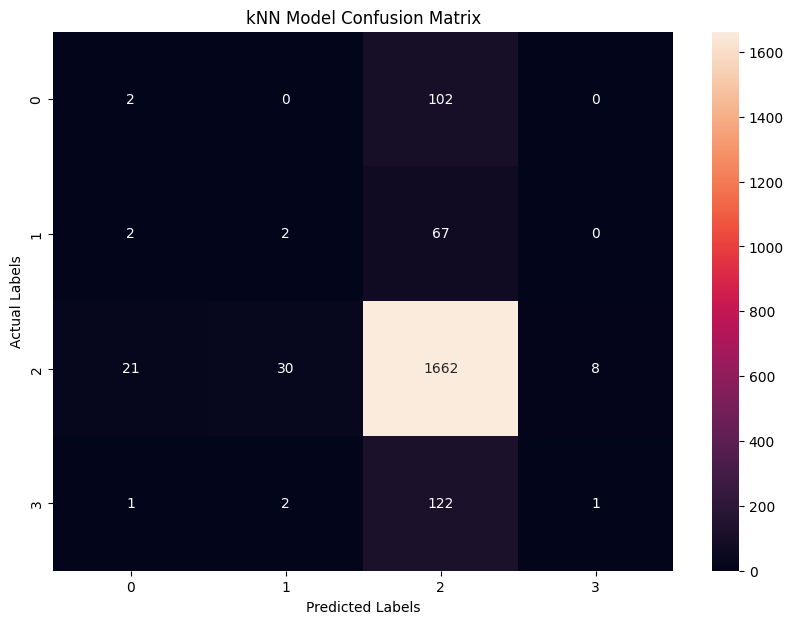

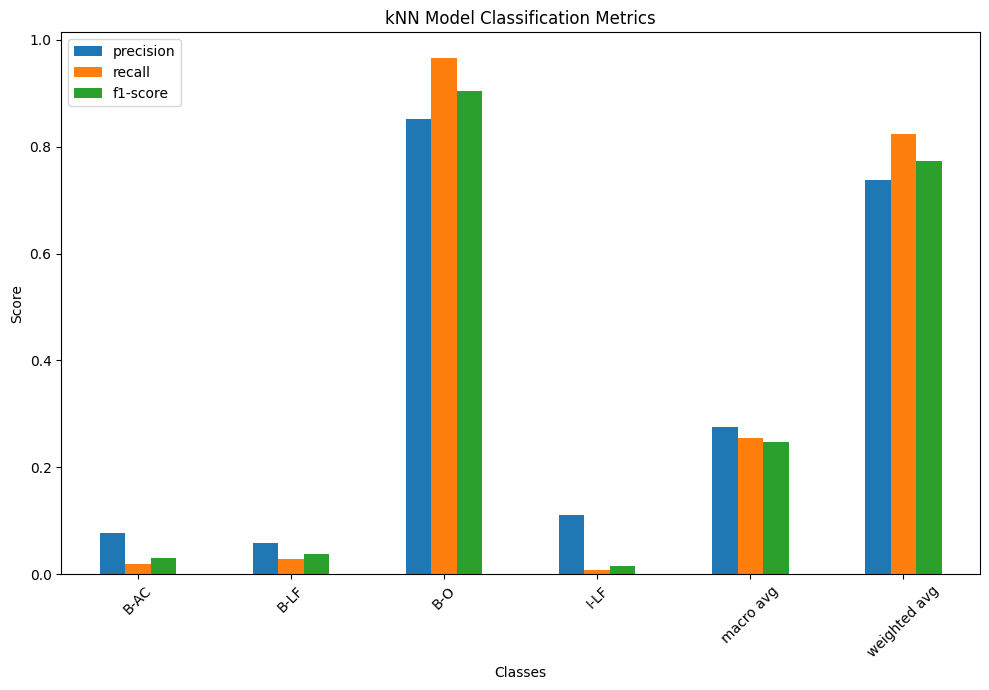

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate classification report
report_knn = classification_report(y_test, y_pred, output_dict=True)

# Convert report to DataFrame
report_knn_df = pd.DataFrame(report_knn).transpose()

# Display classification report table
print(report_knn_df)

# Confusion matrix
cm_knn = confusion_matrix(y_test, y_pred)

# Plotting confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_knn, annot=True, fmt='d')
plt.title('kNN Model Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Plotting bar chart for classification metrics
report_knn_df.drop(['accuracy'], inplace=True)  # Drop the total accuracy row
report_knn_df['support'] = report_knn_df.support.apply(lambda s: int(s))  # Convert support to integer for plotting
report_knn_df.plot(kind='bar', y=['precision', 'recall', 'f1-score'], figsize=(10, 7))

plt.title('kNN Model Classification Metrics')
plt.ylabel('Score')
plt.xlabel('Classes')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
import gensim.downloader as api

# We load the pretrained GloVe model
glove_model = api.load("glove-wiki-gigaword-100")  # It uses 100 dimensional vectors

# Create embedding matrix as previously described
embedding_dim = 100  # Dimension according to GloVe model used above
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = glove_model[word]  # Search the vector for the word
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except KeyError:
        continue  # Word not found in GloVe model

# We integrate the embedding matrix into the model
model = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Bidirectional(LSTM(units=64, return_sequences=True)),
    TimeDistributed(Dense(output_dim, activation='softmax'))
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

[==================================================] 100.0% 128.1/128.1MB downloaded
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 217, 100)          879400    
                                                                 
 bidirectional_2 (Bidirecti  (None, 217, 128)          84480     
 onal)                                                           
                                                                 
 time_distributed_2 (TimeDi  (None, 217, 4)            516       
 stributed)                                                      
                                                                 
Total params: 964396 (3.68 MB)
Trainable params: 84996 (332.02 KB)
Non-trainable params: 879400 (3.35 MB)
_________________________________________________________________


Epoch 1/10
34/34 [==============================] - 11s 225ms/step - loss: 0.7306 - accuracy: 0.9029 - val_loss: 0.2000 - val_accuracy: 0.9412
Epoch 2/10
34/34 [==============================] - 8s 235ms/step - loss: 0.1822 - accuracy: 0.9432 - val_loss: 0.1832 - val_accuracy: 0.9439
Epoch 3/10
34/34 [==============================] - 7s 204ms/step - loss: 0.1740 - accuracy: 0.9445 - val_loss: 0.1836 - val_accuracy: 0.9452
Epoch 4/10
34/34 [==============================] - 8s 222ms/step - loss: 0.1653 - accuracy: 0.9477 - val_loss: 0.1685 - val_accuracy: 0.9493
Epoch 5/10
34/34 [==============================] - 7s 212ms/step - loss: 0.1573 - accuracy: 0.9501 - val_loss: 0.1567 - val_accuracy: 0.9541
Epoch 6/10
34/34 [==============================] - 7s 209ms/step - loss: 0.1521 - accuracy: 0.9515 - val_loss: 0.1616 - val_accuracy: 0.9514
Epoch 7/10
34/34 [==============================] - 7s 221ms/step - loss: 0.1474 - accuracy: 0.9532 - val_loss: 0.1515 - val_accuracy: 0.9544
Epoch

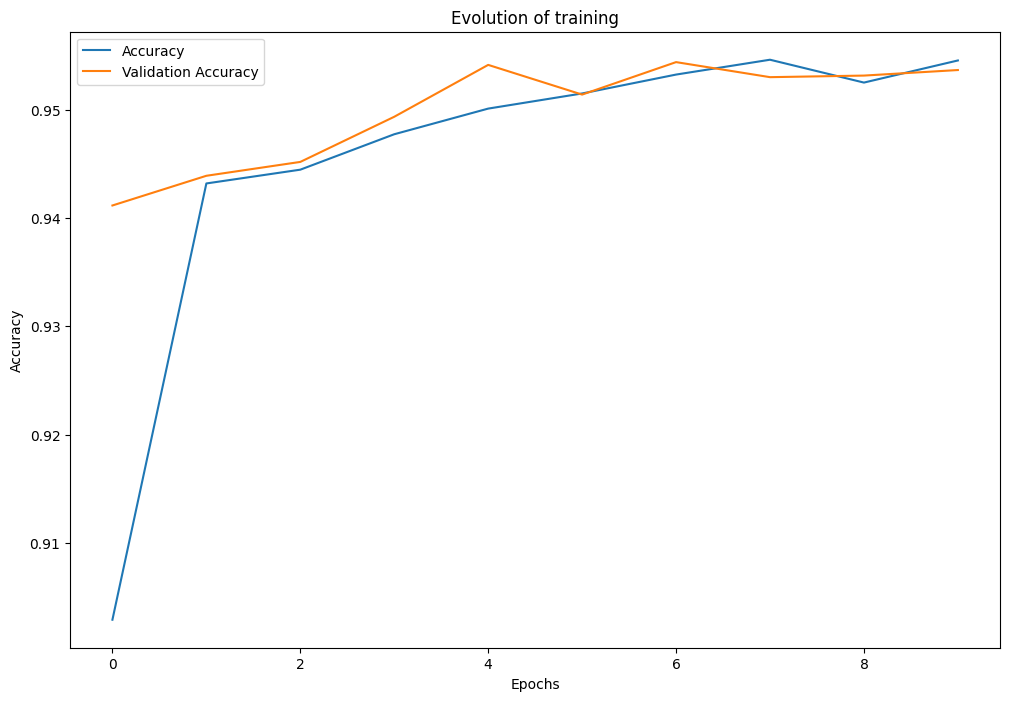

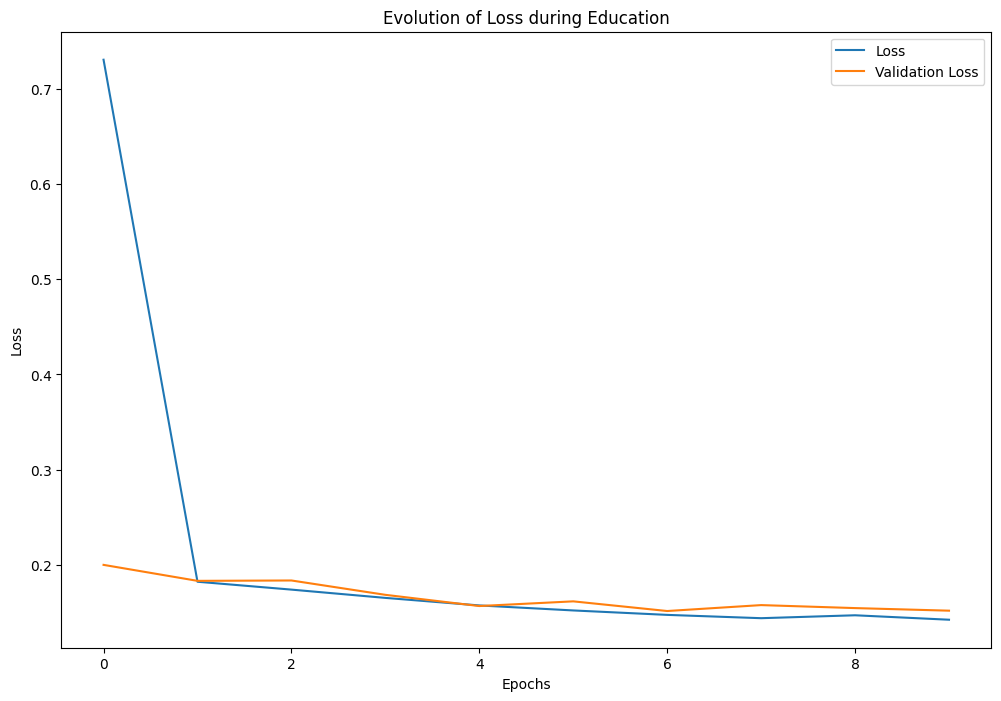

5/5 [==============================] - 1s 125ms/step - loss: 0.1183 - accuracy: 0.9647
Test Loss: 0.11825541406869888, Test Accuracy: 0.9646998643875122
5/5 [==============================] - 2s 129ms/step
Real labels: ['B-LF' 'I-LF' 'B-O' 'B-AC' 'B-O' 'B-O' 'B-O' 'B-O' 'B-O' 'B-O' 'B-O'
 'B-O' 'B-O' 'B-O' 'B-O' 'B-O' 'B-O' 'B-O' 'B-O' 'B-O']
Predicted labels: ['B-O' 'B-O' 'B-O' 'B-O' 'B-O' 'B-O' 'B-O' 'B-O' 'B-O' 'B-O' 'B-O' 'B-O'
 'B-O' 'B-O' 'B-O' 'B-O' 'B-O' 'B-O' 'B-O' 'B-O' 'I-LF' 'I-LF' 'I-LF'
 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF'
 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF'
 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF'
 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF'
 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF'
 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF'
 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-LF' 'I-L

In [ ]:
# Training the model
history = model.fit(
    train_padded,
    np.expand_dims(train_labels_padded, -1),  # The labels on the proper form
    validation_data=(val_padded, np.expand_dims(val_labels_padded, -1)),
    epochs=10,
    batch_size=32
)

# Illustrating the evolution of training
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Evolution of training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Evolution of Loss during Education')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation of the model on the test set
test_loss, test_accuracy = model.evaluate(test_padded, np.expand_dims(test_labels_padded, -1))
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Prediction on the test set and illustration of examples
predictions = model.predict(test_padded)
predicted_labels = np.argmax(predictions, axis=-1)

# Random samples to demonstrate predictions
indices = np.random.choice(range(len(test_labels)), 5, replace=False)
for idx in indices:
    print("Real labels:", label_encoder.inverse_transform(test_labels[idx]))
    print("Predicted labels:", label_encoder.inverse_transform(predicted_labels[idx]))
    print("\n")


In [ ]:
import tensorflow as tf
from tensorflow.keras.metrics import Accuracy, Precision, Recall

# Convert logits to class predictions
predicted_labels = tf.argmax(predictions, axis=-1)

# Prepare a metric object for accuracy and calculate
accuracy_metric = Accuracy()
accuracy_metric.update_state(test_labels_padded, predicted_labels)
test_accuracy = accuracy_metric.result().numpy()

# For F1-score, we need both precision and recall
precision_metric = Precision()
recall_metric = Recall()
precision_metric.update_state(test_labels_padded, predicted_labels)
recall_metric.update_state(test_labels_padded, predicted_labels)
precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()

# Calculate F1 score
if (precision + recall) != 0:
    test_f1_score = 2 * (precision * recall) / (precision + recall)
else:
    test_f1_score = 0

# Print results
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {precision}')
print(f'Test Recall: {recall}')
print(f'Test F1 Score: {test_f1_score}')


Test Accuracy: 0.9646998643875122
Test Precision: 0.99186772108078
Test Recall: 1.0
Test F1 Score: 0.9959172297465114


In [ ]:
import gensim.downloader as api

# We load the pretrained GloVe model
glove_model = api.load("glove-wiki-gigaword-100")  # It uses 100 dimensional vectors

# Create embedding matrix as previously described
embedding_dim = 100  # Dimension according to GloVe model used above
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = glove_model[word]  # Search the vector for the word
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except KeyError:
        continue  # Word not found in GloVe model

# We integrate the embedding matrix into the model
model = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Bidirectional(LSTM(units=64, return_sequences=True)),
    TimeDistributed(Dense(output_dim, activation='softmax'))
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 217, 100)          879400    
                                                                 
 bidirectional_3 (Bidirecti  (None, 217, 128)          84480     
 onal)                                                           
                                                                 
 time_distributed_3 (TimeDi  (None, 217, 4)            516       
 stributed)                                                      
                                                                 
Total params: 964396 (3.68 MB)
Trainable params: 84996 (332.02 KB)
Non-trainable params: 879400 (3.35 MB)
_________________________________________________________________


In [ ]:
import gensim.downloader as api
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# Loading the GloVe model
glove_model = api.load("glove-wiki-gigaword-100")

# Creation of training data
X_train = []
y_train = []

for tokens, tags in zip(train['tokens'], train['ner_tags']):
    for token, tag in zip(tokens, tags):
        token = token.lower()
        if token in glove_model:
            X_train.append(glove_model[token])
            y_train.append(tag)

# Training of KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Data preparation and evaluation
X_test = []
y_test = []

for tokens, tags in zip(test['tokens'], test['ner_tags']):
    for token, tag in zip(tokens, tags):
        token = token.lower()
        if token in glove_model:
            X_test.append(glove_model[token])
            y_test.append(tag)

# Prediction
y_pred = knn_model.predict(X_test)

# Print accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1-Score: {f1}')

Accuracy: 0.8150311526479751
F1-Score: 0.7646011714933185


              precision    recall  f1-score      support
B-AC           0.102564  0.028571  0.044693   140.000000
B-LF           0.046512  0.020408  0.028369    98.000000
B-O            0.844003  0.961681  0.899007  2166.000000
I-LF           0.222222  0.024390  0.043956   164.000000
accuracy       0.815031  0.815031  0.815031     0.815031
macro avg      0.303825  0.258763  0.254006  2568.000000
weighted avg   0.733439  0.815031  0.764601  2568.000000


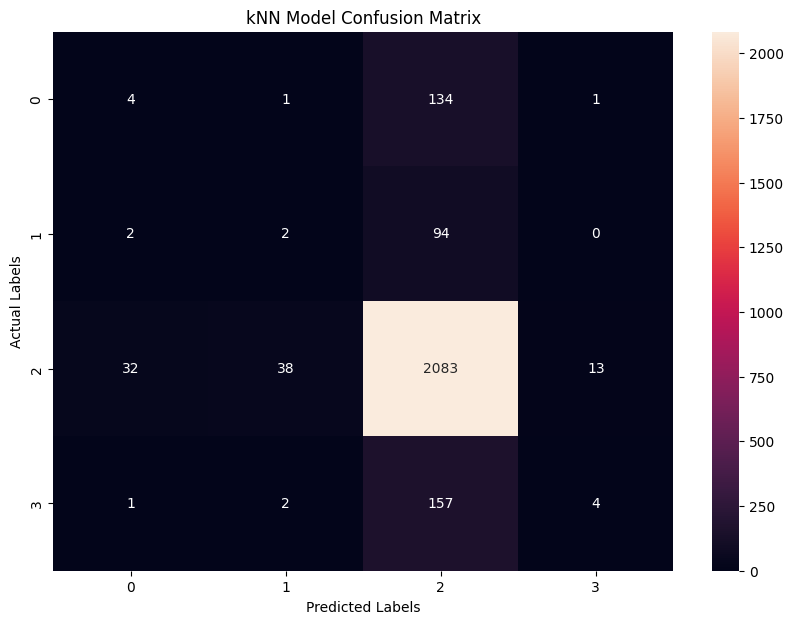

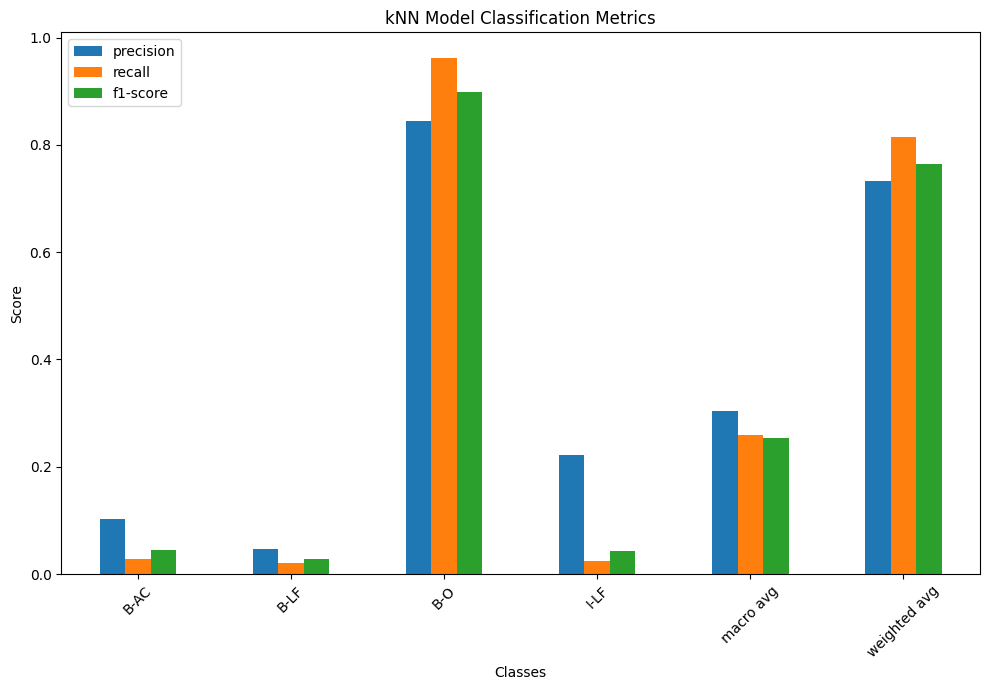

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate classification report
report_knn = classification_report(y_test, y_pred, output_dict=True)

# Convert report to DataFrame
report_knn_df = pd.DataFrame(report_knn).transpose()

# Display classification report table
print(report_knn_df)

# Confusion matrix
cm_knn = confusion_matrix(y_test, y_pred)

# Plotting confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_knn, annot=True, fmt='d')
plt.title('kNN Model Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Plotting bar chart for classification metrics
report_knn_df.drop(['accuracy'], inplace=True)  # Drop the total accuracy row
report_knn_df['support'] = report_knn_df.support.apply(lambda s: int(s))  # Convert support to integer for plotting
report_knn_df.plot(kind='bar', y=['precision', 'recall', 'f1-score'], figsize=(10, 7))

plt.title('kNN Model Classification Metrics')
plt.ylabel('Score')
plt.xlabel('Classes')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Training of KNN
knn_model = KNeighborsClassifier(n_neighbors=100)
knn_model.fit(X_train, y_train)

# Data preparation and evaluation
X_test = []
y_test = []

for tokens, tags in zip(test['tokens'], test['ner_tags']):
    for token, tag in zip(tokens, tags):
        token = token.lower()
        if token in glove_model:
            X_test.append(glove_model[token])
            y_test.append(tag)

# Prediction
y_pred = knn_model.predict(X_test)

# Print accuracy and f1 score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1-Score: {f1}')

Accuracy: 0.8434579439252337
F1-Score: 0.7718335050874762


Accuracy for 1 neighbors: 70.21%
Accuracy for 2 neighbors: 67.68%
Accuracy for 3 neighbors: 76.32%
Accuracy for 4 neighbors: 80.02%
Accuracy for 5 neighbors: 81.50%
Accuracy for 6 neighbors: 82.13%
Accuracy for 7 neighbors: 82.87%
Accuracy for 8 neighbors: 83.18%
Accuracy for 9 neighbors: 83.53%
Accuracy for 10 neighbors: 83.68%
Accuracy for 11 neighbors: 84.15%
Accuracy for 12 neighbors: 84.31%
Accuracy for 13 neighbors: 84.19%
Accuracy for 14 neighbors: 84.31%
Accuracy for 15 neighbors: 84.31%
Accuracy for 16 neighbors: 84.31%
Accuracy for 17 neighbors: 84.31%
Accuracy for 18 neighbors: 84.31%
Accuracy for 19 neighbors: 84.31%
Accuracy for 20 neighbors: 84.31%
Accuracy for 21 neighbors: 84.31%
Accuracy for 22 neighbors: 84.31%
Accuracy for 23 neighbors: 84.31%
Accuracy for 24 neighbors: 84.31%
Accuracy for 25 neighbors: 84.35%
Accuracy for 26 neighbors: 84.35%
Accuracy for 27 neighbors: 84.35%
Accuracy for 28 neighbors: 84.35%
Accuracy for 29 neighbors: 84.35%
Accuracy for 30 neighbo

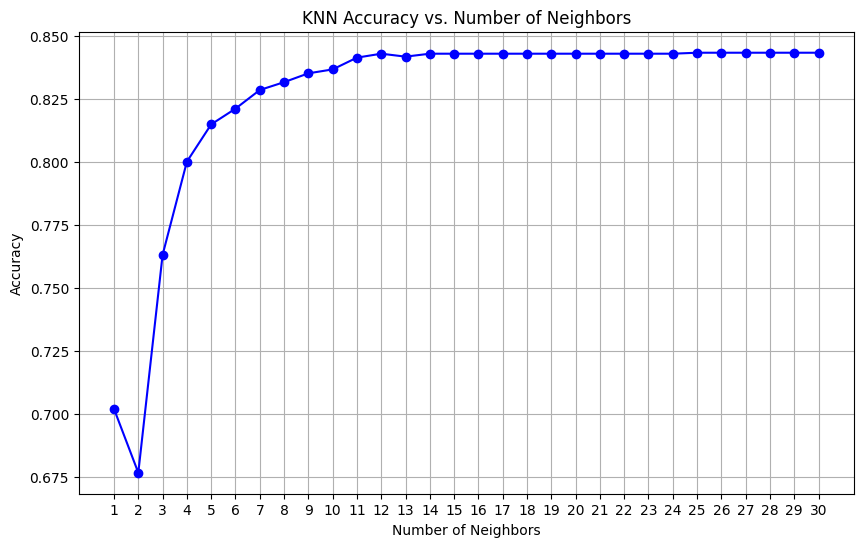

In [ ]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Prepare your test data outside the loop to optimize performance
X_test = []
y_test = []
for tokens, tags in zip(test['tokens'], test['ner_tags']):
    for token, tag in zip(tokens, tags):
        token = token.lower()
        if token in glove_model:
            X_test.append(glove_model[token])
            y_test.append(tag)

# Store accuracies for different values of n_neighbors
accuracies = []
neighbor_range = range(1, 31)  # n_neighbors from 1 to 30

for n_neighbors in neighbor_range:
    # Training of KNN
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(X_train, y_train)

    # Prediction
    y_pred = knn_model.predict(X_test)

    # Calculate and print accuracy and f1 score
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f'Accuracy for {n_neighbors} neighbors: {accuracy:.2%}')
    f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1-Score: {f1}')
# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.plot(neighbor_range, accuracies, marker='o', linestyle='-', color='b')
plt.title('KNN Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(neighbor_range)  # Ensure all neighbor values are marked
plt.show()
